In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
warnings.simplefilter('ignore')
import pytorch_lightning as pl
from obspy.io.segy.segy import _read_segy

In [2]:
class UNet(pl.LightningModule):
    def __init__(self, trainset, testset, num_batch):
        super().__init__()
        self.dec1 = self.Conv3d_x2(1,    2**4)
        self.dec2 = self.Conv3d_x2(2**4, 2**5)
        self.dec3 = self.Conv3d_x2(2**5, 2**6)
        self.cent = self.Conv3d_x2(2**6, 2**9)
        self.enc3 = self.Conv3d_x2(2**9 + 2**6, 2**6)
        self.enc2 = self.Conv3d_x2(2**6 + 2**5, 2**5)
        self.enc1 = self.Conv3d_x2(2**5 + 2**4, 2**4)
        self.fin = nn.Conv3d(2**4, 1, 1)
        torch.nn.init.kaiming_normal_(self.fin.weight)
        self.maxpool = nn.MaxPool3d(2, stride=2, ceil_mode=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)        
        self.trainset = trainset
        self.testset = testset
        self.num_batch = num_batch
        self.epoch = 0
        
    def forward(self, x):
        dec1 = self.dec1(x)
        dec2 = self.dec2(self.maxpool(dec1))
        dec3 = self.dec3(self.maxpool(dec2))
        cent = self.cent(self.maxpool(dec3))
        enc3 = self.enc3(torch.cat([self.upsample(cent), dec3], dim=1))
        enc2 = self.enc2(torch.cat([self.upsample(enc3), dec2], dim=1))
        enc1 = self.enc1(torch.cat([self.upsample(enc2), dec1], dim=1))
        out  = self.fin(enc1)
        return out

    def Conv3d_x2(self, in_channels, out_channels):
        conv3d_x2 = nn.Sequential(
                    nn.Conv3d(in_channels, out_channels, 3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv3d(out_channels , out_channels, 3, padding=1),
                    nn.ReLU(inplace=True),
                    )
        conv3d_x2.apply(self.init_weight_bias)     
        return conv3d_x2
    
    def init_weight_bias(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv3d') == 0:
            torch.nn.init.kaiming_normal_(m.weight)
            
    def configure_optimizers(self):
        optimizer = Adam(model.parameters(), lr=1e-3)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs, labels = self.data_augment(inputs, labels, num_batch=1)
        outputs = self.forward(inputs)
        loss = self.calc_loss(labels, outputs)
        acc = self.binary_acc(labels, outputs)
        logs = {'loss': loss, 'acc': acc}
        return {'loss': loss, 'acc': acc, 'log': logs}

    def training_epoch_end(self, outputs):
        self.epoch += 1        
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc  = torch.stack([x['acc'] for x in outputs]).mean()
        print('Training (Epoch: ' + str(self.epoch) + ')')
        print('Loss: {:.4f}, Acc: {:.4f}'.format(avg_loss, avg_acc))
        logs = {'loss': avg_loss, 'acc': avg_acc}
        return {'loss': avg_loss, 'acc': avg_acc, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs = torch.reshape(inputs, (1,1,128,128,128))
        labels = torch.reshape(labels, (1,1,128,128,128))        
        outputs = self.forward(inputs)
        loss = self.calc_loss(labels, outputs)
        acc = self.binary_acc(labels, outputs)
        logs = {'loss': loss, 'acc': acc}
        return {'val_loss': loss, 'val_acc': acc, 'log': logs}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc  = torch.stack([x['val_acc'] for x in outputs]).mean()        
        logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        
        if self.epoch > 0:
            print('Validation (Epoch: ' + str(self.epoch) + ')')
            print('Loss: {:.4f}, Acc: {:.4f}'.format(avg_loss, avg_acc))
        return {'val_loss': avg_loss, 'log': logs}
    
    def calc_loss(self, labels, outputs):
        # Balanced Cross-Entropy
        count_pos = labels.sum()        # Fault
        count_neg = (1 - labels).sum()  # Non-fault
        beta = torch.as_tensor(count_neg / (count_neg + count_pos))
        pos_weight = torch.where(labels==1, beta / (1 - beta), torch.ones(1).cuda())
        loss = F.binary_cross_entropy_with_logits(outputs, labels, pos_weight=pos_weight)
        return loss * (1 - beta)
    
    def binary_acc(self, labels, outputs):
        y_pred_tag = torch.round(torch.sigmoid(outputs))
        correct_results_sum = torch.eq(y_pred_tag, labels).sum().float()
        acc = correct_results_sum / labels.shape.numel()
        return acc

    def data_augment(self, inputs, labels, num_batch, num_ch=1, num_aug=4, dim=(128,128,128)):
        X = np.zeros([num_batch*num_aug, num_ch, *dim])
        Y = np.zeros([num_batch*num_aug, num_ch, *dim])

        for i in range(num_batch):
            for j in range(num_aug):
                X[num_aug*i+j,] = np.rot90(inputs[i,].cpu(),j,(0,1))
                Y[num_aug*i+j,] = np.rot90(labels[i,].cpu(),j,(0,1))

        inputs_aug = torch.from_numpy(X).float().reshape((num_batch*num_aug, num_ch, *dim))
        labels_aug = torch.from_numpy(Y).float().reshape((num_batch*num_aug, num_ch, *dim))
        return inputs_aug.cuda(), labels_aug.cuda()

    @pl.data_loader
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.num_batch, shuffle=True)

    @pl.data_loader
    def val_dataloader(self):
        return DataLoader(self.testset, batch_size=self.num_batch, shuffle=False)

In [3]:
class SimDataset(Dataset):
    def __init__(self, dpath, fpath, num_data, dim=tuple([128]*3), transform=None):
        self.dpath = dpath
        self.fpath = fpath
        self.dim = dim
        self.num_data = num_data
        self.transform = transform
    
    def __len__(self): 
        return self.num_data
    
    def __getitem__(self, idx):        
        gx  = np.fromfile(os.path.join(self.dpath, str(idx)+'.dat'), dtype=np.single)
        fx  = np.fromfile(os.path.join(self.fpath, str(idx)+'.dat'), dtype=np.single)
        image = torch.as_tensor(gx).reshape(self.dim) # ToTensor cannot be used for 3D numpy array
        mask = torch.as_tensor(fx).reshape(self.dim)
        
        if self.transform:
            image = self.transform(image)
        return [image, mask]

In [4]:
num_data_tr = 200
num_data_val = 20
num_batch = 1
num_epoch = 20
name_dataset = '12.07.2019'
path_home = os.getcwd()
tr_path = os.path.join(path_home, 'dataset', name_dataset, 'train')
vl_path = os.path.join(path_home, 'dataset', name_dataset, 'validation')
tdpath = os.path.join(tr_path, 'seis')
tfpath = os.path.join(tr_path, 'fault')
vdpath = os.path.join(vl_path, 'seis')
vfpath = os.path.join(vl_path, 'fault')

In [5]:
transform = transforms.Compose([transforms.Normalize((-1,), (2,))]) 
trainset = SimDataset(tdpath, tfpath, num_data_tr, transform=transform)
testset  = SimDataset(vdpath, vfpath, num_data_val, transform=transform)
model = UNet(trainset, testset, num_batch)
trainer = pl.Trainer(max_epochs=num_epoch, gpus=1)
#trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [6]:
file_params = 'SegNet_3D_07.28.2020.pt'
#torch.save(model.state_dict(), file_params)
model.load_state_dict(torch.load(file_params))

<All keys matched successfully>

In [7]:
def dataload_segy(path_seis,size_vlm,idx0_vlm):
    ''' This function loads a segy file and quary a subvolume defined by size_vlm and idx0_vlm '''
    file_segy = _read_segy(path_seis).traces
    traces = np.stack([t.data for t in file_segy])
    inlines = np.stack([t.header.for_3d_poststack_data_this_field_is_for_in_line_number for t in file_segy])
    xlines = np.stack([t.header.for_3d_poststack_data_this_field_is_for_cross_line_number for t in file_segy])
    idx_inline = inlines - np.min(inlines)
    idx_xline = xlines - np.min(xlines)
    num_traces = len(traces)
    num_inline = len(np.unique(inlines))
    num_xline = len(np.unique(xlines))
    num_sample = len(file_segy[0].data)
    seis_vlm = np.zeros([num_inline, num_xline, num_sample])
    for i in range(num_traces):
        seis_vlm[idx_inline[i],idx_xline[i],:] = traces[i]
    seis_vlm = seis_vlm[idx0_vlm[0]:idx0_vlm[0]+size_vlm[0],
                        idx0_vlm[1]:idx0_vlm[1]+size_vlm[1],
                        idx0_vlm[2]:idx0_vlm[2]+size_vlm[2]]
    return seis_vlm

In [8]:
def getMask(os,size_subvlm):
    ''' Set gaussian weights in the overlap bounaries '''
    n1, n2, n3 = size_subvlm[0],size_subvlm[1],size_subvlm[2]
    sc = np.zeros(size_subvlm,dtype=np.single)
    sc = sc+1
    sp = np.zeros((os),dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)

    for k1 in range(os):
        for k2 in range(n2):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k1]
                sc[n1-k1-1][k2][k3]=sp[k1]
    for k1 in range(n1):
        for k2 in range(os):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k2]
                sc[k1][n2-k2-1][k3]=sp[k2]
    for k1 in range(n1):
        for k2 in range(n2):
            for k3 in range(os):
                sc[k1][k2][k3]=sp[k3]
                sc[k1][k2][n3-k3-1]=sp[k3]
    return sc

In [9]:
def apply_trained_net(model,seis_vlm,size_subvlm,size_vlm, transform=None):
    '''
    a 3d array of gx[m1][m2][m3], please make sure the dimensions are correct
    we strongly suggest to gain the seismic image before input it to the faultSeg
    '''
    size_vlm = np.shape(seis_vlm)
    n1, n2, n3 = size_subvlm[0],size_subvlm[1],size_subvlm[2]
    m1, m2, m3 = size_vlm[0],size_vlm[1],size_vlm[2]

    stdizer = lambda x: (x - np.mean(x)) / np.std(x)    
    os = 12 #overlap width
    c1 = np.round((m1+os)/(n1-os)+0.5)
    c2 = np.round((m2+os)/(n2-os)+0.5)
    c3 = np.round((m3+os)/(n3-os)+0.5)
    c1 = int(c1)
    c2 = int(c2)
    c3 = int(c3)
    p1 = (n1-os)*c1+os
    p2 = (n2-os)*c2+os
    p3 = (n3-os)*c3+os
    gx = np.reshape(seis_vlm,(m1,m2,m3))
    gp = np.zeros((p1,p2,p3),dtype=np.single)
    gy = np.zeros((p1,p2,p3),dtype=np.single)
    mk = np.zeros((p1,p2,p3),dtype=np.single)
    gs = np.zeros((1,1,*size_subvlm),dtype=np.single)
    gp[0:m1,0:m2,0:m3] = gx
    sc = getMask(os,size_subvlm)
    for k1 in range(c1):
        for k2 in range(c2):
            for k3 in range(c3):
                b1 = k1*n1-k1*os
                e1 = b1+n1
                b2 = k2*n2-k2*os
                e2 = b2+n2
                b3 = k3*n3-k3*os
                e3 = b3+n3
                gs[0,0,:,:,:]=gp[b1:e1,b2:e2,b3:e3]
                gs = stdizer(gs)
                Y = predict(model, gs, transform=transform)                
                Y = np.array(Y)
                gy[b1:e1,b2:e2,b3:e3] = gy[b1:e1,b2:e2,b3:e3]+Y[0,0,:,:,:]*sc
                mk[b1:e1,b2:e2,b3:e3] = mk[b1:e1,b2:e2,b3:e3]+sc
    gy = gy/mk
    pred_vlm = gy[0:m1,0:m2,0:m3]
    return pred_vlm

In [10]:
def predict(model, inputs, transform=None, size_vlm=tuple([128]*3)):
    inputs = torch.as_tensor(np.reshape(inputs, [*size_vlm]))
    if transform:
        output = transform(inputs).reshape((1,1,*size_vlm)).cuda()
    else:
        output = inputs.reshape((1,1,*size_vlm)).cuda()
    pred_vlm = torch.sigmoid(model(output)).detach().cpu().numpy()
    return pred_vlm

In [11]:
def create_img_alpha(img_input,threshold=0.5):
    ''' Overlay a translucent fault image on a seismic image '''
    img_alpha = np.zeros([np.shape(img_input)[0], np.shape(img_input)[1],4])
    img_input[img_input < threshold] = 0
    img_alpha[:,:,0] = 1 # Yellow: (1,1,0), Red: (1,0,0)
    img_alpha[:,:,1] = 0
    img_alpha[:,:,2] = 0
    img_alpha[...,-1] = img_input
    return img_alpha

In [12]:
def show_image_field_data(seis_vlm, pred_vlm, title, idx_slice, threshold=0.5, flag_slice=0):
    ''' Show fault prediction result on field data '''
    seis_vlm = seis_vlm.copy()
    pred_vlm = pred_vlm.copy()
    if   flag_slice == 0:
        seis_slice = seis_vlm[:,:,idx_slice]
        pred_slice = pred_vlm[:,:,idx_slice]
        prefix = 'z-slice'
    elif flag_slice == 1:
        seis_slice = seis_vlm[:,idx_slice,:]
        pred_slice = pred_vlm[:,idx_slice,:]
        prefix = 'y-slice'
    elif flag_slice == 2:
        seis_slice = seis_vlm[idx_slice,:,:]
        pred_slice = pred_vlm[idx_slice,:,:]
        prefix = 'x-slice'
        
    # Display images
    plt.figure(figsize=(14, 6))
    plt.imshow(seis_slice.T,cmap=plt.cm.gray_r,vmin=0.1, vmax=0.9,)
    img_alpha = create_img_alpha(pred_slice.T, threshold)
    plt.imshow(img_alpha, alpha=0.5)
    plt.tick_params(axis='both',which='both',
                    bottom=False,left=False,labelleft=False,labelbottom=False)
    plt.title('F3 Block, ' + prefix + ': ' +str(idx_slice))
    plt.show()

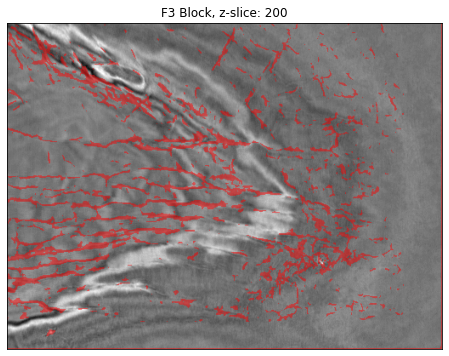

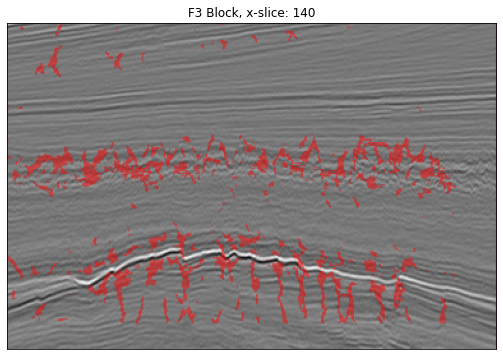

In [13]:
path_seis = './F3_seismic.sgy'
patch_size = 128
size_data = tuple(patch_size*np.array([4,3,2]))
idx0_subvlm = (0,0,200)
model.cuda()

''' Field Data Application '''
standardizer = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))
seis_vlm_F3 = standardizer(dataload_segy(path_seis, size_data, idx0_subvlm))
pred_vlm_F3 = apply_trained_net(model,seis_vlm_F3,tuple([patch_size]*3),size_data, transform)

title = 'F3'
show_image_field_data(seis_vlm_F3, pred_vlm_F3, title, idx_slice=200, threshold=0.9, flag_slice=0)
show_image_field_data(seis_vlm_F3, pred_vlm_F3, title, idx_slice=140, threshold=0.9, flag_slice=2)